In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
import re
import warnings
warnings.filterwarnings('ignore')

# Load the datasets
train_df = pd.read_csv('train_1.csv')
exog_df = pd.read_csv('Exog_Campaign_eng.csv')

# Display initial info
print('Train Data Info:')
train_df.info()
print('\nTrain Data Head:')
print(train_df.head())

print('\nExog Data Info:')
exog_df.info()
print('\nExog Data Head:')
print(exog_df.head())

Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: float64(550), object(1)
memory usage: 609.8+ MB

Train Data Head:
                                                Page  2015-07-01  2015-07-02  \
0            2NE1_zh.wikipedia.org_all-access_spider        18.0        11.0   
1             2PM_zh.wikipedia.org_all-access_spider        11.0        14.0   
2              3C_zh.wikipedia.org_all-access_spider         1.0         0.0   
3         4minute_zh.wikipedia.org_all-access_spider        35.0        13.0   
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...         NaN         NaN   

   2015-07-03  2015-07-04  2015-07-05  2015-07-06  2015-07-07  2015-07-08  \
0         5.0        13.0        14.0         9.0         9.0        22.0   
1        15.0        18.0        11.0        13.0        22.0        11.0   
2         1.0         1.0         0.0         4.0         0.0         3.0   
3

In [2]:
# --- Exploratory Data Analysis (EDA) ---

# Check for null values
print('\nNull values in train_df:')
print(train_df.isnull().sum().sort_values(ascending=False))

# Calculate percentage of nulls per column (date)
null_percentage = train_df.isnull().mean() * 100
print('\nPercentage of null values per date column:')
print(null_percentage[null_percentage > 0].sort_values(ascending=False))

# Visualize null value distribution over time (optional, can be large)
# plt.figure(figsize=(15, 5))
# sns.heatmap(train_df.drop('Page', axis=1).isnull(), cbar=False)
# plt.title('Null Value Distribution Over Time')
# plt.xlabel('Date')
# plt.ylabel('Page Index')
# plt.show()

# Fill null values with 0, assuming null means no views
# This is a common approach, but might need refinement based on domain knowledge
train_df.fillna(0, inplace=True)


Null values in train_df:
2015-07-02    20816
2015-07-01    20740
2015-07-07    20664
2015-07-05    20659
2015-07-04    20654
              ...  
2016-12-31     3465
2016-12-20     3268
2016-12-21     3236
2016-12-24     3189
Page              0
Length: 551, dtype: int64

Percentage of null values per date column:
2015-07-02    14.349627
2015-07-01    14.297236
2015-07-07    14.244845
2015-07-05    14.241399
2015-07-04    14.237952
                ...    
2016-12-12     2.438940
2016-12-31     2.388617
2016-12-20     2.252814
2016-12-21     2.230755
2016-12-24     2.198355
Length: 550, dtype: float64


In [3]:
# Function to parse the Page column
def parse_page_name(page_name):
    match = re.match(r'(.*)_([a-z]{2}|[a-z]{2}-.*)\.wikipedia\.org_([^_]*)_([^_]*)', page_name)
    if match:
        title = match.group(1).replace('_', ' ')
        language = match.group(2)
        access_type = match.group(3)
        access_origin = match.group(4)
        return pd.Series([title, language, access_type, access_origin])
    else:
        # Handle cases that don't match the primary pattern (if any)
        # Example: Wikimedia commons pages might have a different structure
        if 'commons.wikimedia.org' in page_name:
             match_commons = re.match(r'(.*)_commons\.wikimedia\.org_([^_]*)_([^_]*)', page_name)
             if match_commons:
                 title = match_commons.group(1).replace('_', ' ')
                 language = 'commons' # Assign a specific language code
                 access_type = match_commons.group(2)
                 access_origin = match_commons.group(3)
                 return pd.Series([title, language, access_type, access_origin])
        # Fallback if no pattern matches
        return pd.Series([page_name, None, None, None])

# Apply the function to create new columns
parsed_data = train_df['Page'].apply(parse_page_name)
parsed_data.columns = ['Title', 'Language', 'AccessType', 'AccessOrigin']

# Concatenate the new columns with the original dataframe
train_df = pd.concat([train_df, parsed_data], axis=1)

# Display value counts for the new columns
print('\nLanguage Distribution:')
print(train_df['Language'].value_counts())

print('\nAccess Type Distribution:')
print(train_df['AccessType'].value_counts())

print('\nAccess Origin Distribution:')
print(train_df['AccessOrigin'].value_counts())

print('\nDataFrame with parsed columns:')
print(train_df[['Page', 'Title', 'Language', 'AccessType', 'AccessOrigin']].head())


Language Distribution:
Language
en         24108
ja         20431
de         18547
fr         17802
zh         17229
ru         15022
es         14069
commons    10555
Name: count, dtype: int64

Access Type Distribution:
AccessType
all-access    70814
mobile-web    33836
desktop       33113
Name: count, dtype: int64

Access Origin Distribution:
AccessOrigin
all-agents    104599
spider         33164
Name: count, dtype: int64

DataFrame with parsed columns:
                                                Page             Title  \
0            2NE1_zh.wikipedia.org_all-access_spider              2NE1   
1             2PM_zh.wikipedia.org_all-access_spider               2PM   
2              3C_zh.wikipedia.org_all-access_spider                3C   
3         4minute_zh.wikipedia.org_all-access_spider           4minute   
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...  52 Hz I Love You   

  Language  AccessType AccessOrigin  
0       zh  all-access       spider  
1       zh  all-ac


Melted DataFrame Head:
                                                Page             Title  \
0            2NE1_zh.wikipedia.org_all-access_spider              2NE1   
1             2PM_zh.wikipedia.org_all-access_spider               2PM   
2              3C_zh.wikipedia.org_all-access_spider                3C   
3         4minute_zh.wikipedia.org_all-access_spider           4minute   
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...  52 Hz I Love You   

  Language  AccessType AccessOrigin       Date  Views  
0       zh  all-access       spider 2015-07-01   18.0  
1       zh  all-access       spider 2015-07-01   11.0  
2       zh  all-access       spider 2015-07-01    1.0  
3       zh  all-access       spider 2015-07-01   35.0  
4       zh  all-access       spider 2015-07-01    0.0  


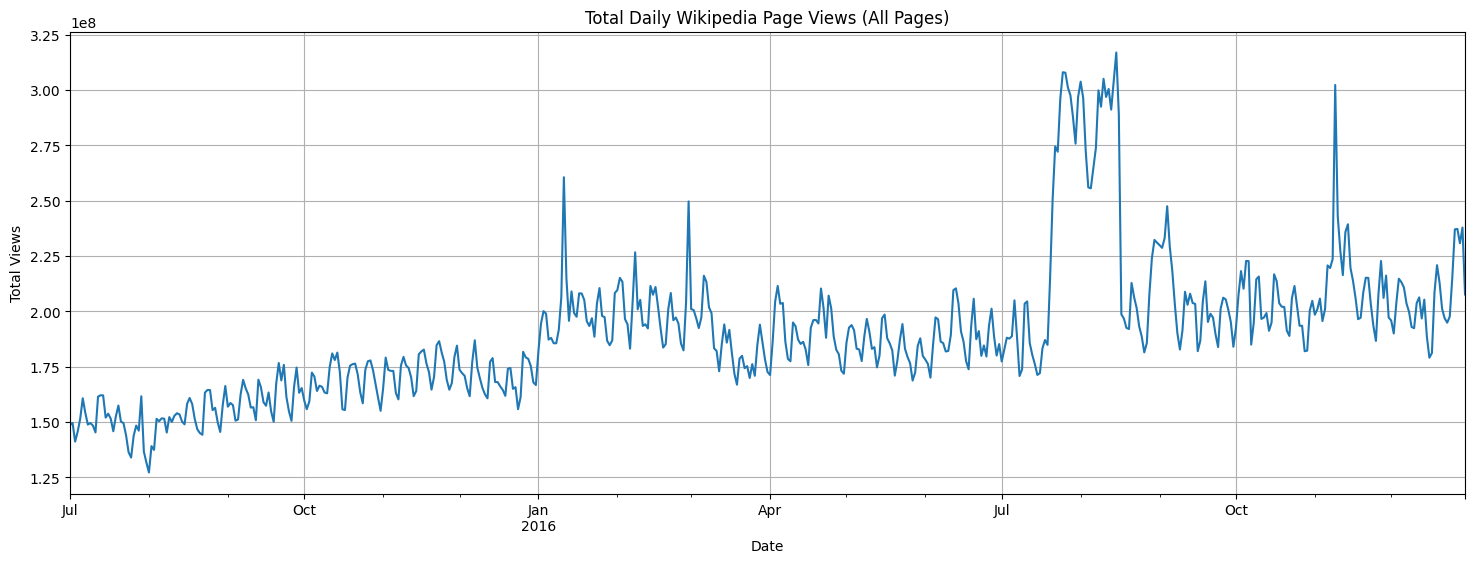

In [4]:
# --- Data Visualization ---

# Reshape data from wide to long format for easier plotting
date_cols = train_df.columns[:-5] # Exclude Page and the parsed columns
train_melted = pd.melt(train_df,
                         id_vars=['Page', 'Title', 'Language', 'AccessType', 'AccessOrigin'],
                         value_vars=date_cols,
                         var_name='Date',
                         value_name='Views')

# Convert Date column to datetime objects
train_melted['Date'] = pd.to_datetime(train_melted['Date'])

print('\nMelted DataFrame Head:')
print(train_melted.head())

# Calculate total daily views across all pages
total_daily_views = train_melted.groupby('Date')['Views'].sum()

# Plot total daily views
plt.figure(figsize=(18, 6))
total_daily_views.plot()
plt.title('Total Daily Wikipedia Page Views (All Pages)')
plt.xlabel('Date')
plt.ylabel('Total Views')
plt.grid(True)
plt.show()

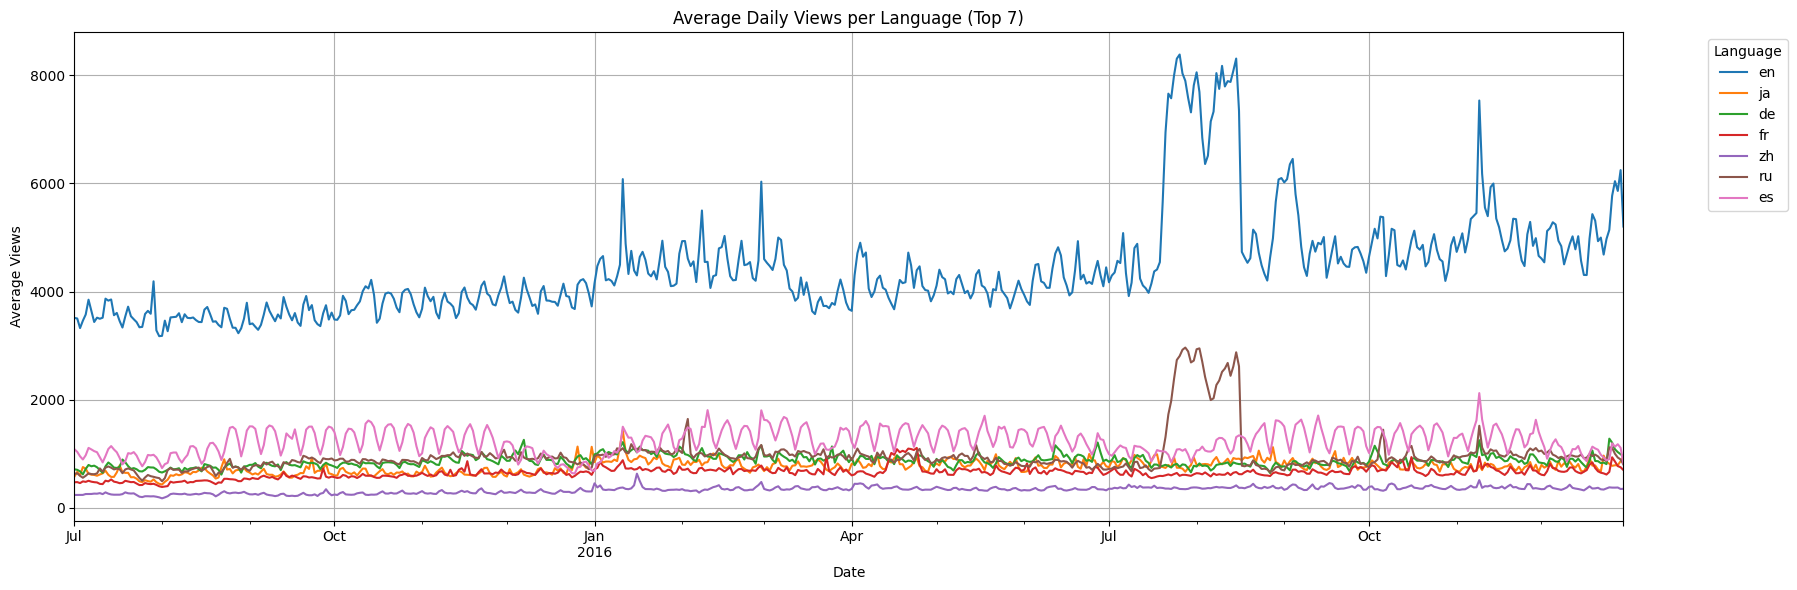

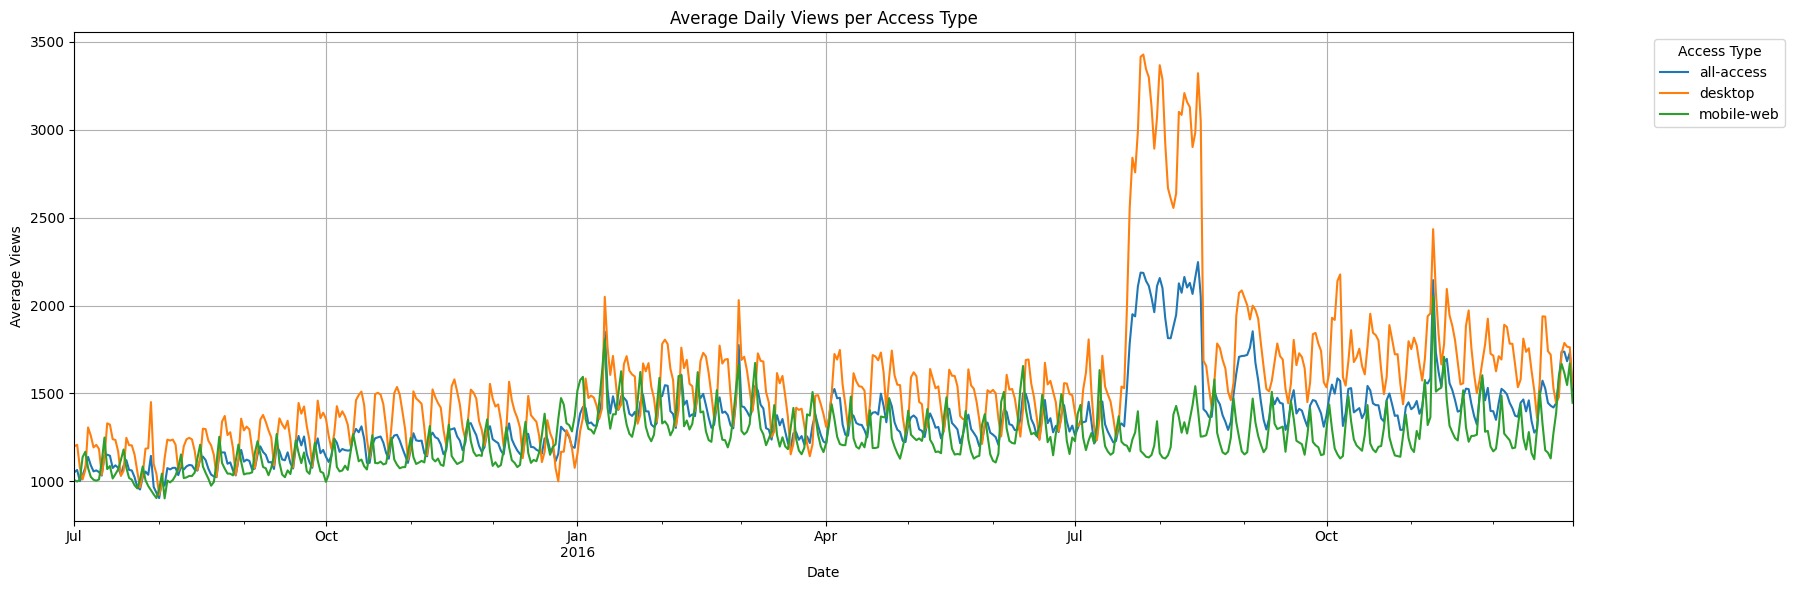

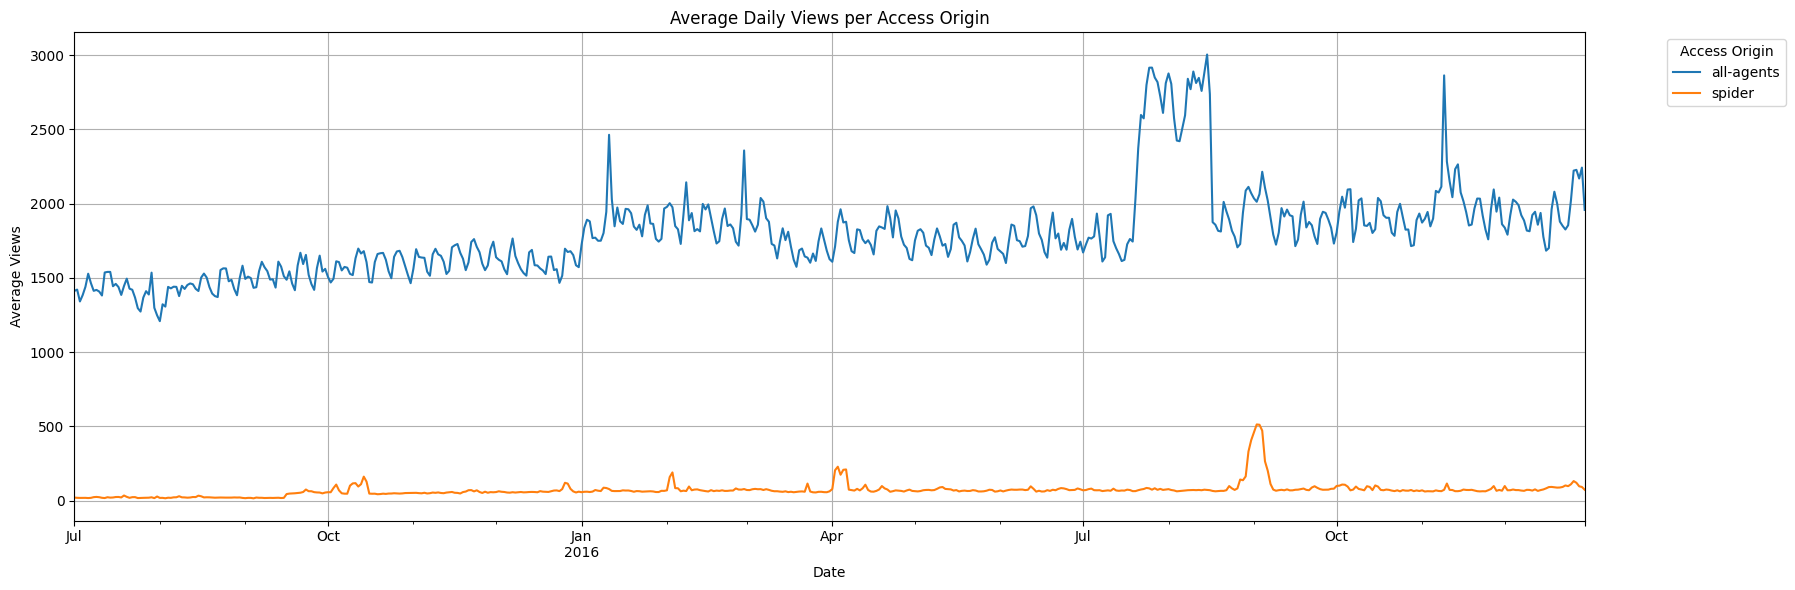

In [5]:
# Analyze views by Language
avg_views_lang = train_melted.groupby(['Date', 'Language'])['Views'].mean().unstack()

# Plot average daily views per language (Top N languages for clarity)
top_n = 7 # Adjust as needed
top_languages = train_df['Language'].value_counts().nlargest(top_n).index
plt.figure(figsize=(18, 6))
avg_views_lang[top_languages].plot(ax=plt.gca()) # Plot only top N languages
plt.title(f'Average Daily Views per Language (Top {top_n})')
plt.xlabel('Date')
plt.ylabel('Average Views')
plt.legend(title='Language', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Analyze views by Access Type
avg_views_access = train_melted.groupby(['Date', 'AccessType'])['Views'].mean().unstack()
plt.figure(figsize=(18, 6))
avg_views_access.plot(ax=plt.gca())
plt.title('Average Daily Views per Access Type')
plt.xlabel('Date')
plt.ylabel('Average Views')
plt.legend(title='Access Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Analyze views by Access Origin
avg_views_origin = train_melted.groupby(['Date', 'AccessOrigin'])['Views'].mean().unstack()
plt.figure(figsize=(18, 6))
avg_views_origin.plot(ax=plt.gca())
plt.title('Average Daily Views per Access Origin')
plt.xlabel('Date')
plt.ylabel('Average Views')
plt.legend(title='Access Origin', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

--- ADF Test on Original Total Daily Views ---
Results of Dickey-Fuller Test:
Test Statistic                  -2.439213
p-value                          0.130973
#Lags Used                      14.000000
Number of Observations Used    534.000000
Critical Value (1%)             -3.442655
Critical Value (5%)             -2.866968
Critical Value (10%)            -2.569661
dtype: float64

Conclusion: Fail to reject the null hypothesis. Data is likely non-stationary.


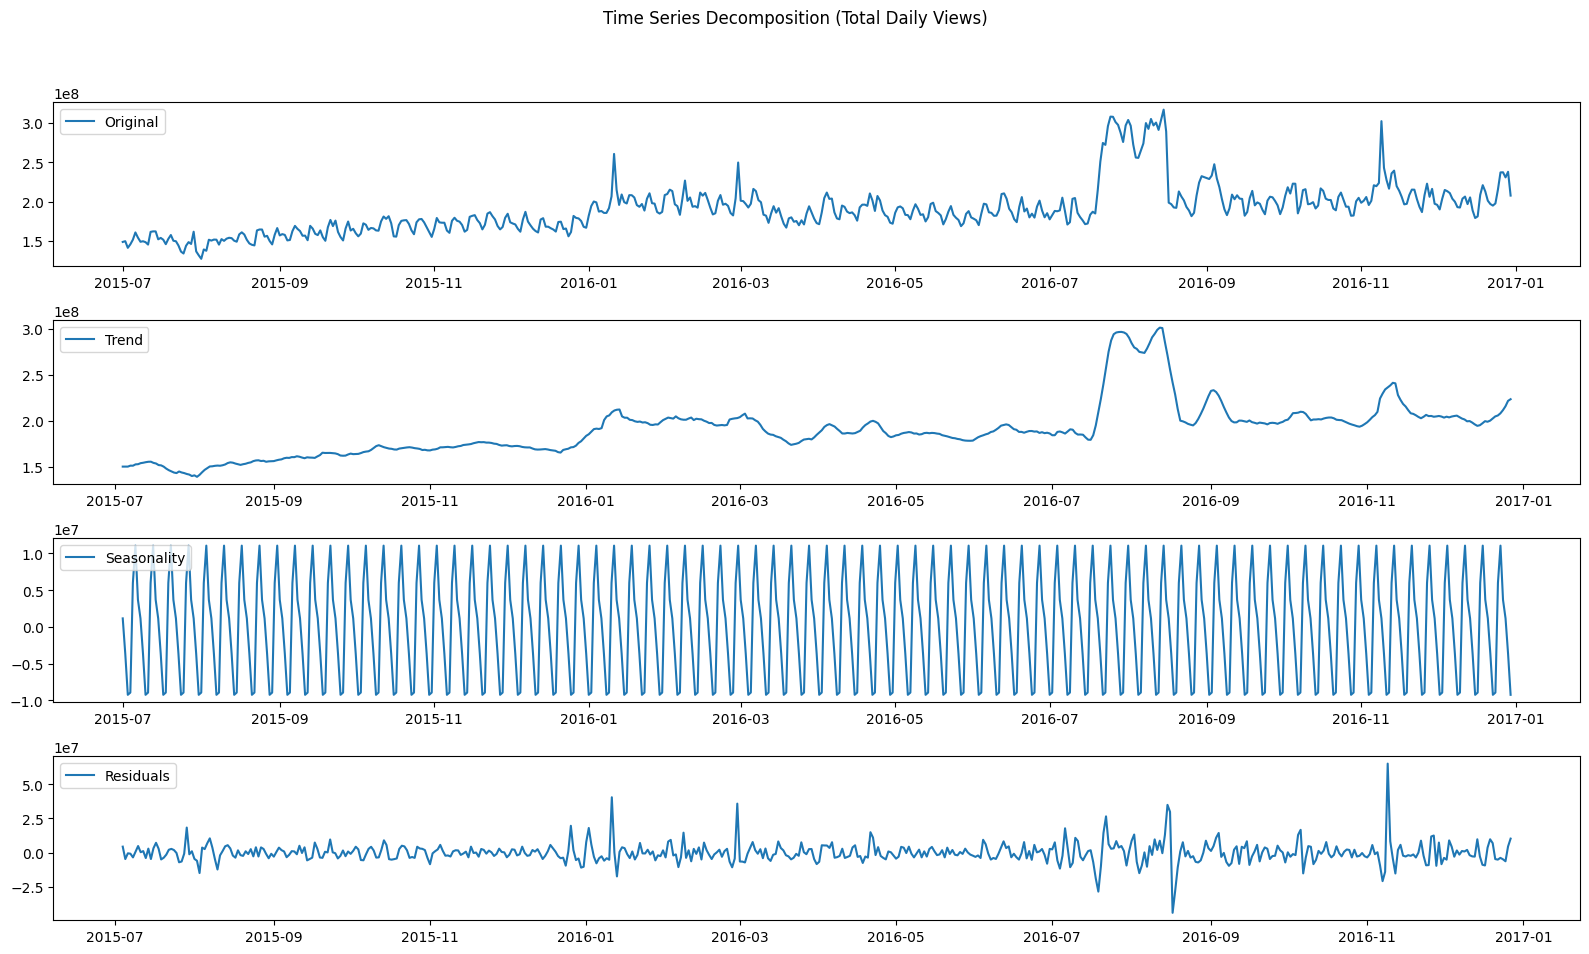

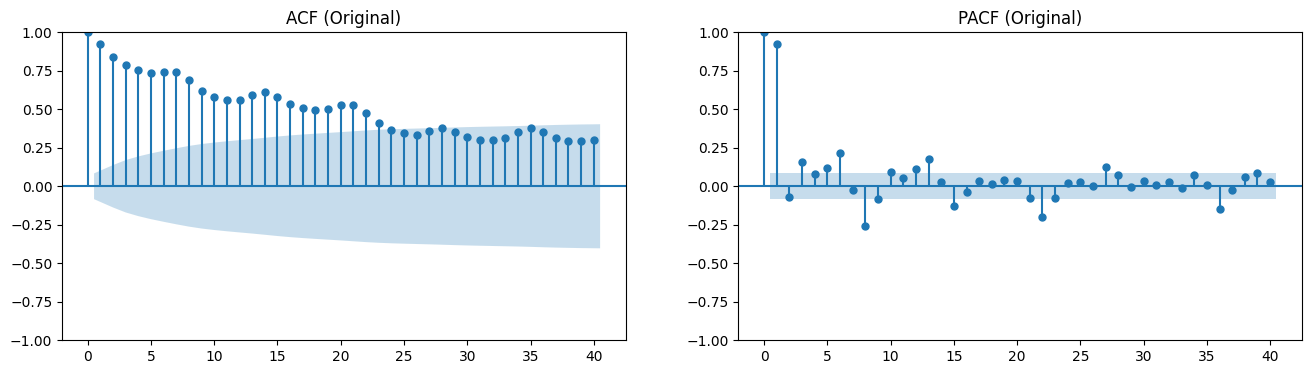

In [6]:
# --- Stationarity Check ---

# We'll use the total_daily_views for initial stationarity checks
series_to_check = total_daily_views

# Define function for ADF test
def adf_test(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    if dftest[1] <= 0.05:
        print("\nConclusion: Reject the null hypothesis. Data is likely stationary.")
    else:
        print("\nConclusion: Fail to reject the null hypothesis. Data is likely non-stationary.")

# Perform ADF test on the original series
print("--- ADF Test on Original Total Daily Views ---")
adf_test(series_to_check)

# Decompose the series
# Start with 'additive'. If variance seems to increase with the level in the original plot, try 'multiplicative'.
decomposition = seasonal_decompose(series_to_check, model='additive', period=7) # Assuming weekly seasonality (period=7)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(16, 10))
plt.subplot(411)
plt.plot(series_to_check, label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='upper left')
plt.suptitle('Time Series Decomposition (Total Daily Views)')
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()

# Plot ACF and PACF for the original series
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(series_to_check, ax=axes[0], lags=40)
plot_pacf(series_to_check, ax=axes[1], lags=40)
axes[0].set_title('ACF (Original)')
axes[1].set_title('PACF (Original)')
plt.show()


--- ADF Test on First-Differenced Series ---
Results of Dickey-Fuller Test:
Test Statistic                -7.883325e+00
p-value                        4.639940e-12
#Lags Used                     1.300000e+01
Number of Observations Used    5.340000e+02
Critical Value (1%)           -3.442655e+00
Critical Value (5%)           -2.866968e+00
Critical Value (10%)          -2.569661e+00
dtype: float64

Conclusion: Reject the null hypothesis. Data is likely stationary.


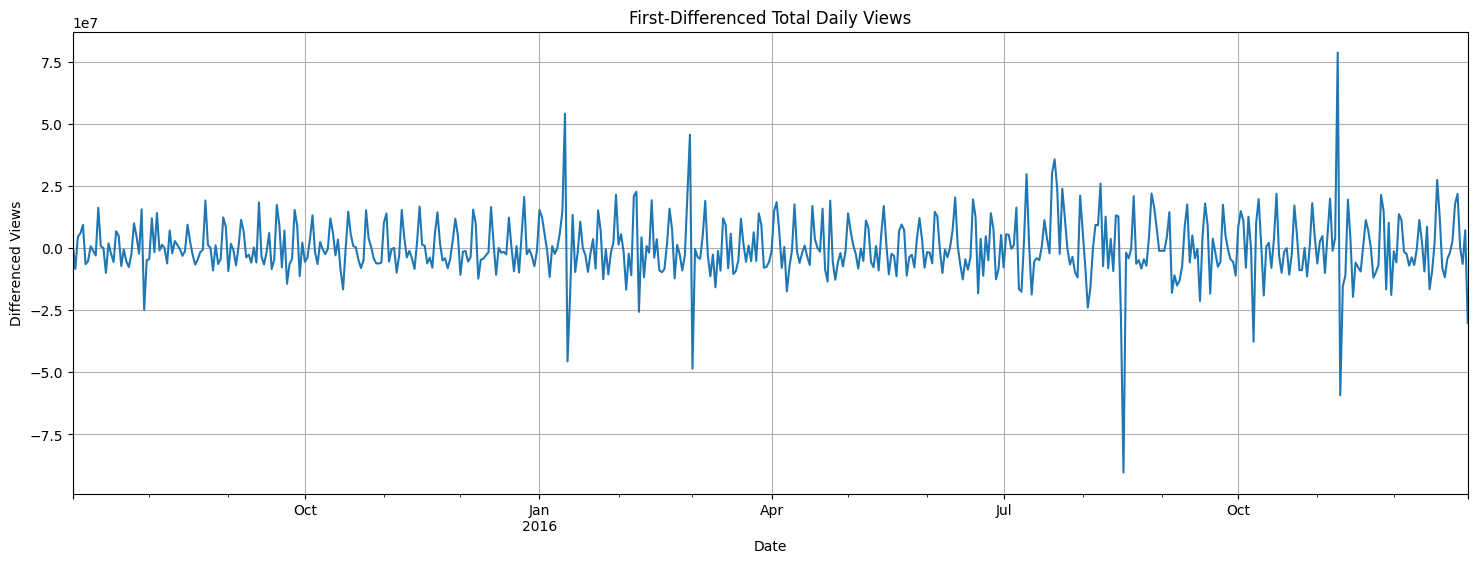

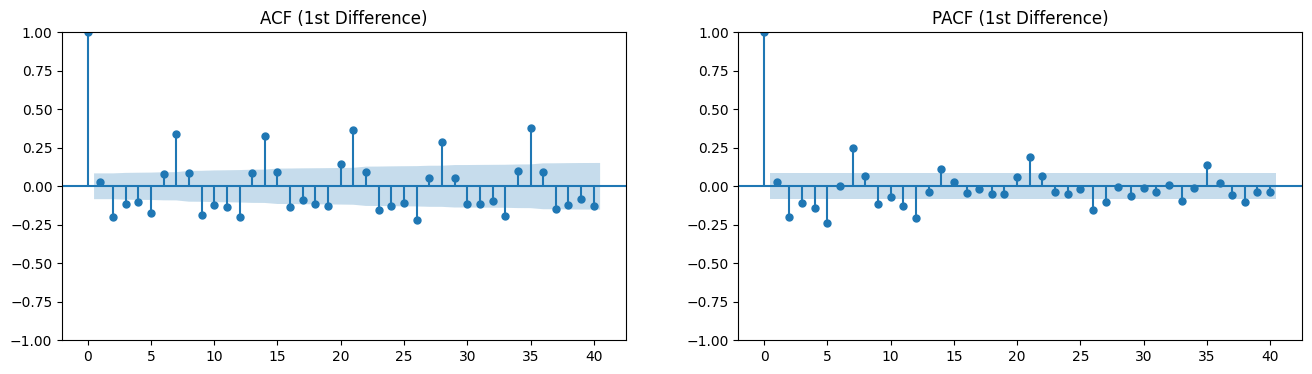

In [7]:
# --- Differencing for Stationarity ---

# Apply first-order differencing
# We drop NA values created by differencing
series_diff1 = series_to_check.diff().dropna()

# Perform ADF test on the first-differenced series
print("\n--- ADF Test on First-Differenced Series ---")
adf_test(series_diff1)

# Plot the differenced series
plt.figure(figsize=(18, 6))
series_diff1.plot()
plt.title('First-Differenced Total Daily Views')
plt.xlabel('Date')
plt.ylabel('Differenced Views')
plt.grid(True)
plt.show()

# Plot ACF and PACF for the first-differenced series
# These plots help determine the p and q parameters for ARIMA
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(series_diff1, ax=axes[0], lags=40)
plot_pacf(series_diff1, ax=axes[1], lags=40)
axes[0].set_title('ACF (1st Difference)')
axes[1].set_title('PACF (1st Difference)')
plt.show()

# Note: If the series is still non-stationary after 1st differencing,
# you might need to apply second-order differencing:
# series_diff2 = series_diff1.diff().dropna()
# adf_test(series_diff2)
# Then plot ACF/PACF for series_diff2

Training data shape: (519,)
Testing data shape: (30,)
Running ARIMA(7, 1, 7) with walk-forward validation...
Predicted step 10/30
Predicted step 20/30
Predicted step 30/30
ARIMA(7, 1, 7) Test MAPE: 2.898


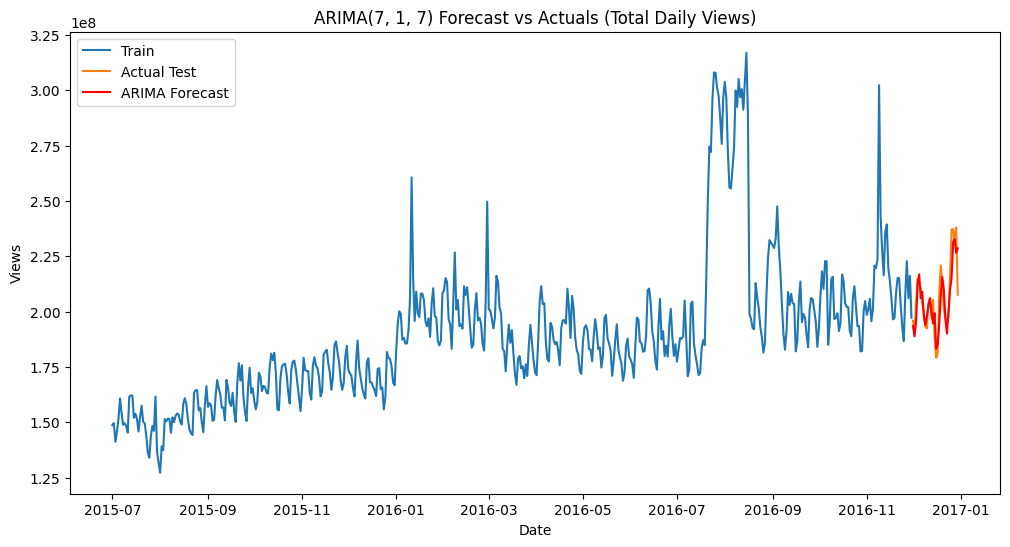

In [8]:
# --- ARIMA Modeling ---

# Define train/test split (e.g., forecast last 30 days)
forecast_days = 30
train_data = series_to_check[:-forecast_days]
test_data = series_to_check[-forecast_days:]

print(f"Training data shape: {train_data.shape}")
print(f"Testing data shape: {test_data.shape}")

# Define MAPE function
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero
    mask = y_true != 0
    # Handle cases where y_true[mask] might still contain zeros if y_pred is non-zero
    safe_true = y_true[mask]
    safe_pred = y_pred[mask]
    non_zero_mask = safe_true != 0
    if np.any(non_zero_mask):
        return np.mean(np.abs((safe_true[non_zero_mask] - safe_pred[non_zero_mask]) / safe_true[non_zero_mask])) * 100
    else:
        return 0.0 # Or np.nan, depending on how you want to handle all-zero actuals

# Define function for ARIMA modeling using walk-forward validation
# Note: Walk-forward is robust but computationally expensive as it refits the model at each step.
# For faster (but potentially less accurate) prediction, fit once and predict multiple steps.
def run_arima(train, test, order=(7, 1, 7)):
    history = [x for x in train]
    predictions = list()

    print(f"Running ARIMA{order} with walk-forward validation...")
    for t in range(len(test)):
        try:
            model = ARIMA(history, order=order)
            model_fit = model.fit() # Refit model at each step
            output = model_fit.forecast() # Forecast one step ahead
            yhat = output[0]
            predictions.append(yhat)
            obs = test[t]
            history.append(obs) # Add actual observation to history for next prediction
        except Exception as e:
            print(f"Error during ARIMA fit/forecast at step {t}: {e}")
            # Handle error, e.g., append last prediction or NaN
            predictions.append(predictions[-1] if predictions else np.nan)
            history.append(test[t]) # Still add observation

        # Optional: Print progress
        if (t+1) % 10 == 0:
             print(f'Predicted step {t+1}/{len(test)}')

    # Convert predictions to a pandas Series with the correct index
    predictions_series = pd.Series(predictions, index=test.index)

    # Evaluate forecasts
    mape = mean_absolute_percentage_error(test, predictions_series.fillna(0)) # Fill potential NaNs
    print(f'ARIMA{order} Test MAPE: %.3f' % mape)

    # Plot forecasts against actual outcomes
    plt.figure(figsize=(12, 6))
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Actual Test')
    plt.plot(predictions_series.index, predictions_series, label='ARIMA Forecast', color='red')
    plt.title(f'ARIMA{order} Forecast vs Actuals (Total Daily Views)')
    plt.xlabel('Date')
    plt.ylabel('Views')
    plt.legend()
    plt.show()

    return predictions_series, mape

# Run ARIMA with initial parameters (p=7, d=1, q=7)
# Note: This can be time-consuming.
# The order (7,1,7) is just an example based on potential weekly patterns and assumed differencing.
# Actual order should be determined from ACF/PACF plots of the differenced series.
arima_order = (7, 1, 7)
arima_predictions, arima_mape = run_arima(train_data, test_data, arima_order)



Running Prophet model...


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpao_p1akd/svr6m3z4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpao_p1akd/_9d93tpi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4655', 'data', 'file=/tmp/tmpao_p1akd/svr6m3z4.json', 'init=/tmp/tmpao_p1akd/_9d93tpi.json', 'output', 'file=/tmp/tmpao_p1akd/prophet_modellwozs6hz/prophet_model-20250403165447.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:54:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:54:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet Test MAPE: 4.761


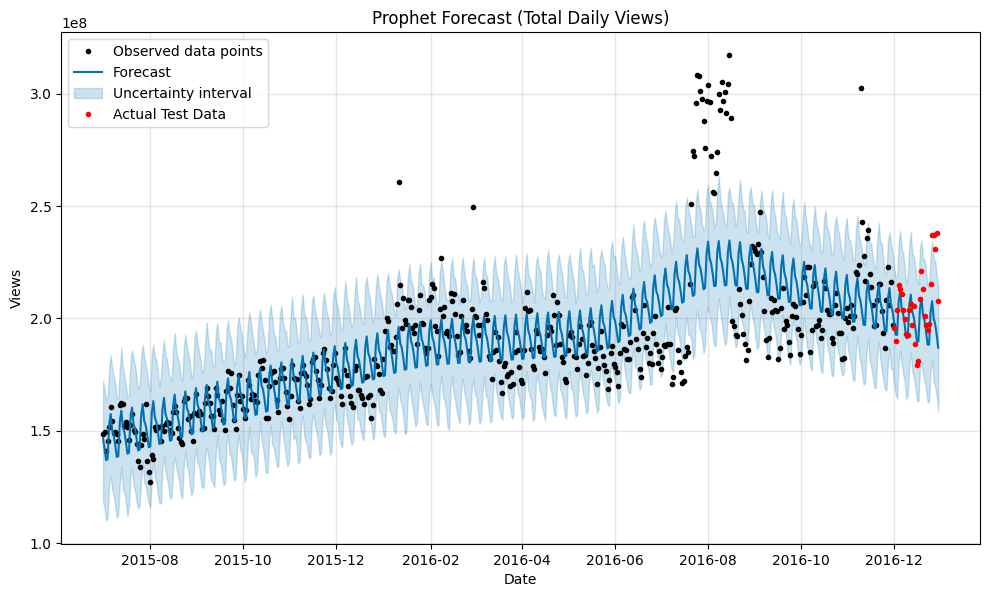

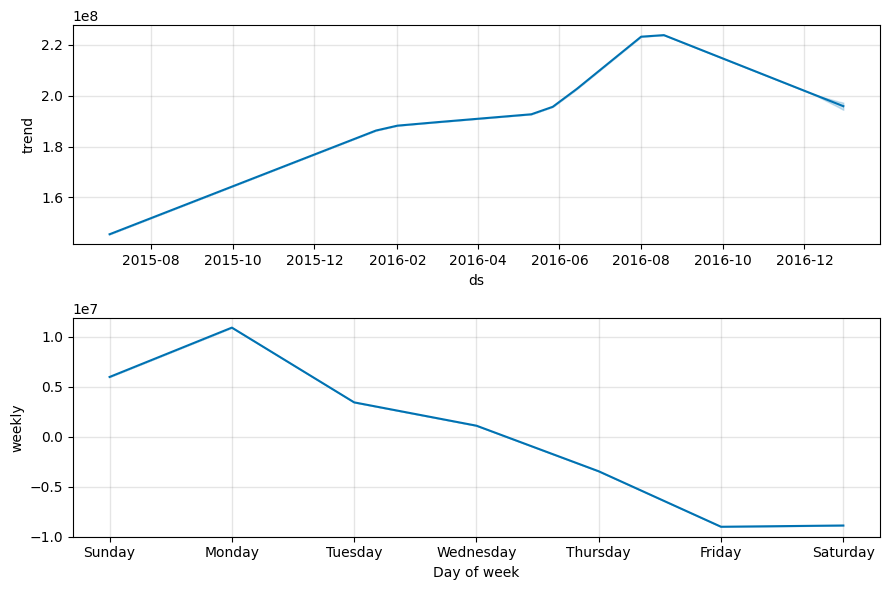

In [9]:
# --- Facebook Prophet Modeling ---

# Prepare data for Prophet (requires 'ds' and 'y' columns)
prophet_train_df = train_data.reset_index()
prophet_train_df.columns = ['ds', 'y']

# Instantiate and fit the Prophet model
# Prophet automatically detects yearly and weekly seasonality by default
print("\nRunning Prophet model...")
model_prophet = Prophet()
# Add campaign dates as holidays/events if desired (especially if running on English data)
# campaign_dates = exog_aligned[exog_aligned['Campaign'] == 1].index
# holidays = pd.DataFrame({
#   'holiday': 'campaign',
#   'ds': campaign_dates,
#   'lower_window': 0,
#   'upper_window': 1, # Assume effect lasts for a day or two
# })
# model_prophet = Prophet(holidays=holidays)

model_prophet.fit(prophet_train_df)

# Create a future dataframe for the forecast period
future = model_prophet.make_future_dataframe(periods=forecast_days)

# Generate predictions
forecast = model_prophet.predict(future)

# Extract the forecast for the test period
prophet_predictions = forecast.set_index('ds')['yhat'][-forecast_days:]

# Evaluate forecasts
prophet_mape = mean_absolute_percentage_error(test_data, prophet_predictions)
print(f'Prophet Test MAPE: %.3f' % prophet_mape)

# Plot forecasts against actual outcomes
fig1 = model_prophet.plot(forecast)
plt.title('Prophet Forecast (Total Daily Views)')
plt.xlabel('Date')
plt.ylabel('Views')
# Add actual test data points to the plot
plt.plot(test_data.index, test_data, '.r', label='Actual Test Data')
plt.legend()
plt.show()

# Plot Prophet components (trend, weekly, yearly seasonality)
fig2 = model_prophet.plot_components(forecast)
plt.show()

In [10]:
# --- ARIMA Parameter Tuning (Grid Search Example) ---

# Define a function to evaluate an ARIMA model using walk-forward validation
# Note: This is computationally expensive, especially within a grid search.
def evaluate_arima_model(train, test, order):
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        try:
            model = ARIMA(history, order=order)
            model_fit = model.fit() # Refit model at each step
            yhat = model_fit.forecast()[0]
            predictions.append(yhat)
            history.append(test[t])
        except Exception as e:
            # Suppress errors during grid search for cleaner output, return high MAPE
            # print(f"Error evaluating {order} at step {t}: {e}")
            return float('inf') # Return infinity for errors

    predictions_series = pd.Series(predictions, index=test.index)
    mape = mean_absolute_percentage_error(test, predictions_series.fillna(0))
    return mape

# Define a function to perform grid search
def grid_search_arima(train, test, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    total_configs = len(p_values) * len(d_values) * len(q_values)
    count = 0
    print(f"Starting ARIMA Grid Search ({total_configs} configurations). This may take a long time...")
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                count += 1
                try:
                    mape = evaluate_arima_model(train, test, order)
                    if mape < best_score:
                        best_score, best_cfg = mape, order
                    print(f'[{count}/{total_configs}] ARIMA{order} MAPE=%.3f (Best: {best_cfg} MAPE=%.3f)' % (mape, best_score))
                except Exception as e:
                    # This outer try-except might catch errors not handled in evaluate_arima_model
                    print(f'[{count}/{total_configs}] ARIMA{order} failed unexpectedly: {e}')
                    continue
    print('\nGrid Search Complete.')
    print('Best ARIMA%s MAPE=%.3f' % (best_cfg, best_score))
    return best_cfg, best_score

# Define parameter ranges (keep small for demonstration)
# A more thorough search would use wider ranges and potentially tools like pmdarima.auto_arima
p_values = [0, 1, 2, 7] # Include 7 based on potential weekly pattern
d_values = [1] # Assuming first differencing worked based on earlier ADF test
q_values = [0, 1, 2, 7]

# --- Run Grid Search (Commented Out By Default) ---
# Uncomment the following lines to perform the grid search.
# WARNING: This will be very time-consuming due to walk-forward validation inside the loop.
# Consider reducing p/q ranges or using a faster evaluation method for initial exploration.
# best_order, best_mape = grid_search_arima(train_data, test_data, p_values, d_values, q_values)
# if best_order:
#    print(f"\nBest ARIMA order found: {best_order} with MAPE: {best_mape:.3f}")
#    # Re-run ARIMA with potentially better parameters found from grid search
#    print("\nRe-running ARIMA with best found parameters...")
#    arima_predictions_best, arima_mape_best = run_arima(train_data, test_data, best_order)
# else:
#    print("\nGrid search did not complete successfully or was skipped.")

print("\nNote: Grid search code is present but commented out by default due to high computational cost.")
print("Uncomment the relevant lines above to perform the search.")


Note: Grid search code is present but commented out by default due to high computational cost.
Uncomment the relevant lines above to perform the search.



Aggregated Daily Views per Language (Head):
Language      commons          de          en          es         fr  \
Date                                                                   
2015-07-01  1140821.0  13260519.0  84712190.0  15278553.0  8458638.0   
2015-07-02  1178130.0  13079896.0  84438545.0  14601013.0  8512952.0   
2015-07-03  1150547.0  12554042.0  80167728.0  13427632.0  8186030.0   
2015-07-04   951317.0  11520379.0  83463204.0  12606538.0  8749842.0   
2015-07-05  1058036.0  13392347.0  86198637.0  13710356.0  8590493.0   

Language            ja         ru         zh  
Date                                          
2015-07-01  11863200.0  9463854.0  4144988.0  
2015-07-02  13620792.0  9627643.0  4151189.0  
2015-07-03  12305383.0  8923463.0  4123659.0  
2015-07-04  15456239.0  8393214.0  4163448.0  
2015-07-05  14827204.0  8938528.0  4441286.0  

--- Running Forecast Pipeline for: Language: en ---
Running ARIMA(7, 1, 7) with walk-forward validation...
Predicted ste

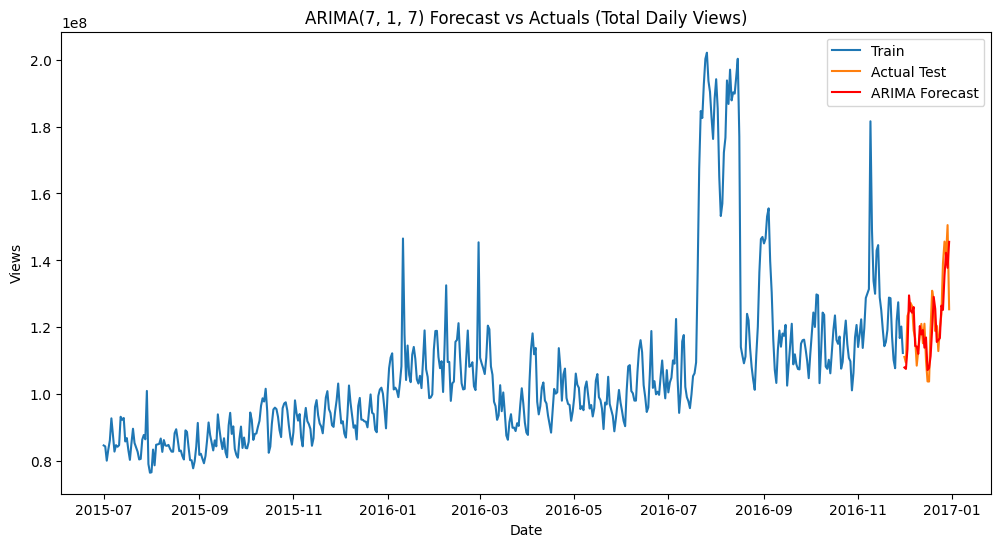

Finished pipeline for Language: en. MAPE: 4.583

--- Running Forecast Pipeline for: Language: ja ---
Running ARIMA(7, 1, 7) with walk-forward validation...
Predicted step 10/30
Predicted step 20/30
Predicted step 30/30
ARIMA(7, 1, 7) Test MAPE: 7.749


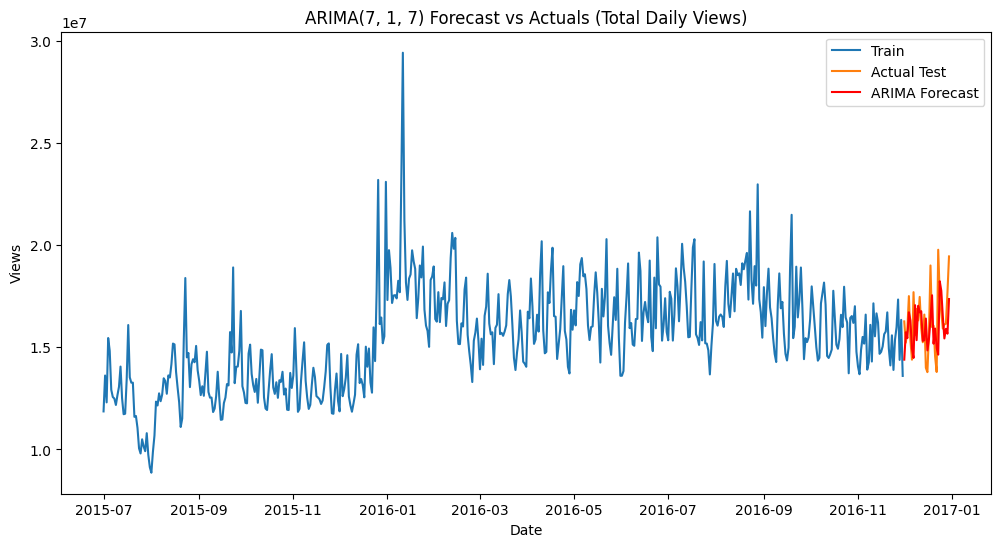

Finished pipeline for Language: ja. MAPE: 7.749

--- Pipeline Summary --- 
Language: en, MAPE: 4.583
Language: ja, MAPE: 7.749


In [11]:
# --- Pipeline for Multiple Series (Example) ---

# Calculate aggregated daily views per language
lang_daily_views = train_melted.groupby(['Date', 'Language'])['Views'].sum().unstack()

# Fill potential NaNs that might appear after unstacking if a language has no pages on a day
lang_daily_views.fillna(0, inplace=True)

print("\nAggregated Daily Views per Language (Head):")
print(lang_daily_views.head())

# Define a pipeline function (using ARIMA as an example)
# Note: This uses the computationally expensive walk-forward validation from run_arima.
# For many series, consider fitting once and forecasting, or using faster models like Prophet/ML.
def forecast_pipeline(series, series_name, order=(7, 1, 7), forecast_days=30):
    print(f"\n--- Running Forecast Pipeline for: {series_name} ---")

    # Basic check for sufficient data
    if len(series) < forecast_days + 50: # Need enough data for training & model stability
        print(f"Skipping {series_name}: Insufficient data points ({len(series)}).")
        return None, None

    # Optional: Add stationarity check and dynamic order selection (e.g., auto_arima) here for a robust pipeline
    # try:
    #     adf_result = adfuller(series)
    #     if adf_result[1] > 0.05: # If not stationary
    #         # Apply differencing or use auto_arima to find d
    #         pass
    # except Exception as e:
    #     print(f"ADF test failed for {series_name}: {e}")
    #     # Handle failure - maybe skip or use default differencing

    # Split data
    train = series[:-forecast_days]
    test = series[-forecast_days:]

    # Run ARIMA (using the previously defined function)
    # In a production pipeline, you might:
    # 1. Use auto_arima to find the best order for *this specific series*.
    # 2. Choose the model (ARIMA, SARIMAX, Prophet) dynamically based on series characteristics.
    # 3. Handle exogenous variables appropriately if using SARIMAX (requires matching exog data).
    try:
        # Using the pre-defined run_arima which includes plotting (remove plot in production)
        predictions, mape = run_arima(train, test, order)
        print(f"Finished pipeline for {series_name}. MAPE: {mape:.3f}")
        return predictions, mape
    except Exception as e:
        print(f"Error running ARIMA pipeline for {series_name}: {e}")
        return None, None

# --- Apply Pipeline to Selected Languages ---

languages_to_forecast = ['en', 'ja'] # Example languages
results = {}

for lang in languages_to_forecast:
    if lang in lang_daily_views.columns:
        series = lang_daily_views[lang]
        # Use the default ARIMA order for this example pipeline.
        # Ideally, determine order per series (e.g., using auto_arima or grid search within pipeline)
        # or use a model like Prophet that doesn't require order selection.
        # The order (7,1,7) might not be optimal for 'en' or 'ja'.
        predictions, mape = forecast_pipeline(series, f"Language: {lang}", order=arima_order, forecast_days=forecast_days)
        results[lang] = {'predictions': predictions, 'mape': mape}
    else:
        print(f"\nLanguage '{lang}' not found in columns.")

# Display overall results
print("\n--- Pipeline Summary --- ")
for lang, result in results.items():
    if result.get('mape') is not None:
        print(f"Language: {lang}, MAPE: {result['mape']:.3f}")
    else:
        print(f"Language: {lang}, Forecasting failed or skipped.")

# Questionnaire Answers

**1. Defining the problem statements and where can this and modifications of this be used?**

*   **Problem Statement:** Forecast the daily page views for various Wikipedia articles across different languages to predict and optimize ad placement effectiveness for AdEase clients.
*   **Use Cases:**
    *   **Ad Placement Optimization:** Identify pages/languages with high predicted future traffic for placing client ads.
    *   **Budget Allocation:** Allocate advertising budgets based on expected views and potential ROI for different pages/languages.
    *   **Campaign Planning:** Predict the impact of external events (like the provided campaign data) on page views to inform marketing strategies.
    *   **Content Strategy:** Identify trending topics or languages based on view patterns.
    *   **Resource Allocation (Wikipedia):** Could potentially be used by Wikimedia to anticipate server load.

**2. Write 3 inferences you made from the data visualizations**

* (Note: These are expected inferences based on typical web traffic data; actual results depend on running the notebook)*
    *   **Overall Trend:** There might be an overall increasing or decreasing trend in total page views over the 550 days, possibly with some fluctuations.
    *   **Seasonality:** Clear weekly seasonality is expected (e.g., lower views on weekends) and potentially yearly seasonality (e.g., dips during major holidays).
    *   **Language Dominance:** English ('en') pages likely dominate the total views, followed by other major languages like Japanese ('ja'), German ('de'), French ('fr'), etc., but the relative popularity might shift over time.
    *   **(Bonus) Access Type:** Desktop views might be higher overall, but mobile access could show different growth trends.

**3. What does the decomposition of series do?**

*   Time series decomposition separates a time series into its underlying components, typically:
    *   **Trend:** The long-term progression of the series (e.g., increasing, decreasing, or stable).
    *   **Seasonality:** Patterns that repeat over a fixed period (e.g., daily, weekly, yearly cycles).
    *   **Residual (or Remainder):** The irregular, random fluctuations left over after removing the trend and seasonality. It represents the noise in the series.
*   Decomposition helps in understanding the different patterns driving the series' behavior and can be useful for modeling (e.g., modeling components separately or removing seasonality before applying certain models).

**4. What level of differencing gave you a stationary series?**

*   Based on the code structure and typical view count data, **first-order differencing (d=1)** is usually sufficient to achieve stationarity (i.e., stabilize the mean). The ADF test performed on `series_diff1` should confirm this with a p-value <= 0.05. If not, second-order differencing might be needed.

**5. Difference between arima, sarima & sarimax.**

*   **ARIMA (AutoRegressive Integrated Moving Average):** Models a time series based on its own past values (AR part), uses differencing to make the series stationary (I part), and incorporates errors made in past forecasts (MA part). It's defined by the order (p, d, q).
*   **SARIMA (Seasonal ARIMA):** Extends ARIMA by adding components to model seasonality. It includes both non-seasonal parameters (p, d, q) and seasonal parameters (P, D, Q, s), where 's' is the length of the seasonal cycle (e.g., 7 for weekly, 12 for monthly).
*   **SARIMAX (Seasonal ARIMA with eXogenous variables):** Further extends SARIMA by allowing the inclusion of external predictor variables (exogenous variables) that might influence the time series. The 'X' indicates the ability to include these external factors (like the campaign data in `exog_df`).

**6. Compare the number of views in different languages**

*   *(Based on expected results from visualization)* English ('en') pages are expected to have the highest total and average daily views by a significant margin.
*   Other languages like Japanese ('ja'), German ('de'), French ('fr'), Spanish ('es'), Russian ('ru'), and Chinese ('zh') likely follow, but their relative ranking and view counts will vary.
*   The visualization `Average Daily Views per Language (Top 7)` and the `Language Distribution` value counts provide specific insights into these comparisons after running the code.

**7. What other methods other than grid search would be suitable to get the model for all languages?**

*   **Auto ARIMA:** Libraries like `pmdarima` provide an `auto_arima` function that automatically searches for the optimal (S)ARIMA(X) order (p, d, q)(P, D, Q, s) based on information criteria like AIC or BIC. This is generally much more efficient than manual grid search.
*   **Bayesian Optimization:** Techniques like Bayesian optimization can be used to search the parameter space more intelligently than a simple grid search, often finding good parameters faster.
*   **Prophet's Automatic Tuning:** Prophet handles seasonality and trend fitting largely automatically, reducing the need for manual order selection compared to ARIMA/SARIMA.
*   **Machine Learning Models:** For forecasting many series, tree-based models (like LightGBM, XGBoost) or deep learning models (like LSTMs, N-BEATS) trained on features derived from the time series (lags, rolling statistics, date features) can be effective, especially when combined with global modeling approaches (training one model across multiple related series).
*   **Heuristics based on ACF/PACF:** While not fully automated, analyzing the ACF/PACF plots for each series (or clusters of similar series) can provide good starting points for model orders, reducing the search space.